<h1 align='center'>==============================================================================<br>==============================================================================<br>RIPE ATLAS PROBES IN THE NETHERLANDS </h1>

In this Jupyter Notebook we (1) collect all the RIPE Atlas probes in the Netherlands, (2) enrich the ASN of the found probes with their AS name, and (3) visualize the distribution of probes in the Netherlands.

<h1 align='center'>==============================================================================<br>==============================================================================<br>DATA PREPARATION</h1>

#### NEEDED LIBRARIES

In [114]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore') #To avoid showing annoying warns

from ripe.atlas.cousteau import ProbeRequest, Probe, Measurement

## GETTING INFORMATION OF RIPE ATLAS PROBES IN THE NETHERLANDS

In [14]:
df = pd.DataFrame()

filters = {"country_code": "NL"}
probes = ProbeRequest(**filters)

for probe in probes:
    print(probe["id"])
    current_probe = Probe(id=probe["id"])
    df = df.append({'id': current_probe.id, 
                    'asn_v4': current_probe.asn_v4,
                    'is_public':current_probe.is_public},
                   ignore_index=True
                  )

1
2
3
4
5
6
7
8
9
10
12
13
15
16
17
18
19
20
21
22
23
26
27
29
31
34
35
36
37
38
42
92
94
107
167
174
191
194
236
237
246
293
318
322
340
429
438
443
475
529
535
580
631
642
667
782
835
875
880
939
945
946
957
964
977
989
997
999
1049
1165
1213
1261
1332
1334
1347
1374
1377
1423
1429
1452
1490
1521
1522
1523
2002
2009
2015
2020
2038
2047
2048
2055
2063
2082
2114
2116
2133
2166
2174
2180
2192
2293
2296
2311
2315
2321
2357
2374
2385
2387
2396
2407
2416
2424
2425
2462
2463
2471
2476
2491
2523
2527
2561
2565
2580
2585
2597
2611
2635
2672
2691
2709
2745
2786
2797
2883
2913
2951
2980
3019
3039
3045
3056
3070
3081
3108
3109
3113
3120
3124
3130
3144
3148
3153
3158
3161
3170
3180
3209
3212
3215
3237
3248
3254
3264
3274
3278
3286
3308
3331
3353
3355
3364
3377
3379
3420
3488
3494
3497
3511
3536
3549
3555
3594
3608
3622
3623
3632
3647
3654
3846
3965
3967
3976
3987
4024
4052
4137
4170
4186
4190
4201
4221
4227
4247
4273
4283
4293
4321
4357
4367
4408
4463
4484
4501
4504
4544
4560
4600
4604
4605
4608


#### QUICK PREVIEW OF THE DATA

In [38]:
df.head()

,asn_v4,id,is_public
0,3265.0,1.0,1.0
1,1136.0,2.0,0.0
2,NaN,3.0,1.0
3,3265.0,4.0,1.0
4,3265.0,5.0,1.0


#### TOTAL NUMBER OF PROBES

In [17]:
total_probes_nl = len(df)
total_probes_nl

1228

#### PREPARING THE COLUMN ASN_V4 TO BE ENRICHED

In [87]:
df['asn_v4'] = df['asn_v4'].apply(lambda x: 'AS'+str(x).replace('.0',''))

## FUNCTION TO LOOK-UP A LIST OF ASNs AND RETURN THEIR AS-NAME

In [91]:
import subprocess
import os.path
import random
import time
import pandas as pd

def teamcymru_asn_lookup_bulk(pandaseries):
    iptoasn_response = open('output_ip2asn_teamcymru.txt', 'w')

    #Creating the request file containing a list of IPs
    #For more information, please access: http://www.team-cymru.com/IP-ASN-mapping.html
    iptoasn_request = open('input_ip2asn_teamcymru.txt', 'w')
    iptoasn_request.write('begin\nverbose\n')
    pd.Series(pandaseries.dropna().unique()).to_csv(iptoasn_request,header=False,index=False,sep="\t") 
    iptoasn_request.write('end')
    iptoasn_request.close()

    #Performing the bulk request
    cat = subprocess.Popen(['cat', 'input_ip2asn_teamcymru.txt'], stdout=subprocess.PIPE)
    print(cat)
    netcat = subprocess.Popen(['netcat', 'whois.cymru.com', '43'], stdin=cat.stdout, stdout=iptoasn_response)
    print (netcat)
    time.sleep(3) #for some reason the poll does not work! This was the way to overcome the waiting time.
    #Closing the output file
    iptoasn_response.close()

    df = pd.read_csv('output_ip2asn_teamcymru.txt',\
                     skiprows=1,\
                     delimiter="\s+\|\s",\
                     names = ['asn', 'country', 'registry', 'info_date','as_name'])

    ### CAN BE USEFUL: 
    ###df['asn'] = df['asn'].astype(str).apply(lambda x: 'AS'+x.split('.')[0])
    
    !rm input_ip2asn_teamcymru.txt
    !rm output_ip2asn_teamcymru.txt
    
    return df

#### USING THE LOOKUP FUNCTION 

In [92]:
df_asn_lookup = teamcymru_asn_lookup_bulk(df['asn_v4'])

#### PREPARING THE LOOKUP DATA TO BE MERGED

In [94]:
df_asn_lookup['asn'] = df_asn_lookup['asn'].apply(lambda x: 'AS'+str(x))

#### MERGING THE LOOKUP DATA WITH THE ORIGINAL DATA

In [101]:
df_extended = pd.merge(df,df_asn_lookup[['asn','as_name']],
                          how = 'left',
                          left_on = 'asn_v4',
                          right_on = 'asn')

#### CREATING A NEW COLUMN THAT COMBINES THE ASN AND A SHORT VERSION OF THE AS-NAME

In [134]:
df_extended['asn_short'] = df_extended['asn']+':'+df_extended['as_name'].str.split().str[0].str.split('-').str[0]

#### QUICK PREVIEW OF THE PROCESSED DATA

In [135]:
df_extended.head()

,asn_v4,id,is_public,asn,as_name,asn_short
0,AS3265,1.0,1.0,AS3265,"XS4ALL-NL Amsterdam, NL",AS3265:XS4ALL
1,AS1136,2.0,0.0,AS1136,KPN This macro reflects our filtering-policy o...,AS1136:KPN
2,ASnan,3.0,1.0,NaN,NaN,NaN
3,AS3265,4.0,1.0,AS3265,"XS4ALL-NL Amsterdam, NL",AS3265:XS4ALL
4,AS3265,5.0,1.0,AS3265,"XS4ALL-NL Amsterdam, NL",AS3265:XS4ALL


<h1 align='center'>==============================================================================<br>==============================================================================<br>VISUALIZING THE DATA</h1>

#### NEEDED LIBRARIES

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
plt.style.use('ggplot') #For improving the visualization style (options: grayscale, bmh, dark_background, ggplot, and fivethirtyeight)

## DISTRIBUTION OF PUBLIC VS. NON-PUBLIC RIPE ATLAS PROBES

In [136]:
public_probes = df_extended['is_public'].value_counts()

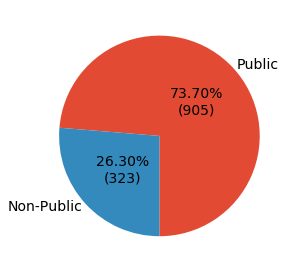

In [137]:
fig = plt.figure(figsize=(4, 4))
fig.suptitle("RIPE Atlas Probes in NL", fontsize=16)

ax1 = plt.subplot2grid((1,1), (0,0))

plt.rcParams.update({'font.size': 14})

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

public_probes.plot(ax=ax1,
                   kind='pie', 
                   autopct=make_autopct(public_probes.values),
                   startangle=270,
                   pctdistance=0.5,
                   labeldistance=1.05,
                   labels=['Public','Non-Public'])

ax1.set_ylabel("")
fig.tight_layout()
fig.show()

fig.suptitle("")
fig.savefig('piechart_ripeatlas_nl_public.eps', bbox_inches='tight',format='eps', dpi=1200, transparent=True)

## DISTRIBUTION OF ASN IN THE NETHERLANDS

In [138]:
frequency_asn = df_exteAded['asn_short'].value_counts()

#### NUMBER OF PROBES WITH ASN AND AS-NAME

In [152]:
probes_with_asn = len(df_extended[~df_extended['asn_short'].isnull()])
probes_with_asn

1087

#### NUMBER OF UNIQUE ASN

In [146]:
unique_asn = len(frequency_asn)
unique_asn

199

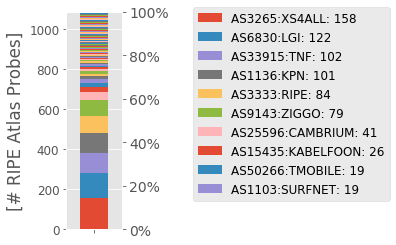

In [171]:
fig = plt.figure(figsize=(1, 4))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

ax2 = plt.subplot2grid((1,1), (0,0))

ax1 = ax2.twinx()
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

frequency_asn.to_frame().T.plot(kind='bar',ax=ax2, legend=False, stacked=True, title="",fontsize=12).set_zorder(1)
ax2.set_xlabel("")
ax2.set_ylabel("[# RIPE Atlas Probes]")
ax2.set_ylim(0,len(df_extended.dropna()))

legend_show_top=10
labels = ['{0}: {1}'.format(i,j) for i,j in zip(frequency_asn.index, frequency_asn.values)]

ax2.legend(ax2.patches[0:legend_show_top], 
         labels[0:legend_show_top], 
           bbox_to_anchor=(5.9, 1.05),
           fontsize=12)
# 
plt.setp( ax2.get_xticklabels(), visible=False)


fig.show()
fig.savefig('distribution_ripeatlas_probes_asn_top10.eps', bbox_inches='tight',format='eps', dpi=1200, transparent=True)

**Notes:** 
- The top 10 ASN cover around 70% of all RIPE Atlas probes in the Netherlands
- LGI (Liberty Global), TNF (Vodafone) and Ziggo were merged!

## NUMBER OF PROBES IN EACH ASN INVOLVED IN ASSESSING LOGIUS QUALITY PEERING PLATFORM (KPP)

In [173]:
print("KPN (AS1136):", len(df_extended[df_extended['asn_v4']=='AS1136']),"probes") 
print("T-Mobile|Tele2 (AS13127):", len(df_extended[df_extended['asn_v4']=='AS13127']),"probes") 
print("LibertyGlobal|Vodafone|Ziggo (AS9143):", len(df_extended[df_extended['asn_v4']=='AS9143']),"probes") 
print("Nikhef (AS1103):", len(df_extended[df_extended['asn_v4']=='AS1103']),"probes") 
print("Equinix Connect (AS47886):", len(df_extended[df_extended['asn_v4']=='AS47886']),"probe") 
print()
print("Logius (AS62003) :", len(df_extended[df_extended['asn_v4']=='AS62003']),"probes") 
print("Logius KPP (AS21027):", len(df_extended[df_extended['asn_v4']=='AS210207']),"probes") 

KPN (AS1136): 101 probes
T-Mobile|Tele2 (AS13127): 13 probes
LibertyGlobal|Vodafone|Ziggo (AS9143): 79 probes
Nikhef (AS1103): 19 probes
Equinix Connect (AS47886): 1 probe

Logius (AS62003) : 0 probes
Logius KPP (AS21027): 0 probes


<h1 align='center'>==============================================================================<br>==============================================================================<br>RELATED MATERIAL</h1>

- List of probes: https://atlas.ripe.net/probes/

- On 18/09/2019 there are 1228 probes in NL (905 are public): https://atlas.ripe.net/probes/?search=&status=&af=&country=NL#!tab-public
- Recently post about "Routing to and from the Netherlands" https://labs.ripe.net/Members/marco_hogewoning/routing-to-and-from-the-netherlands
- There is also the IXP Country Jedi http://sg-pub.ripe.net/ixp-country-jedi/NL/
- There is also the RIS https://www.ripe.net/analyse/internet-measurements/routing-information-service-ris/routing-information-service-ris